# Transfer learning for image classification
## here we take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset
## Using pre-trained model saves lot of time and computational budget for new classification problem at hand

## 1. Import important libraries

In [1]:
import numpy as np
import cv2

import PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## 2. Import ready-made model from tensorflow_hub

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

## make some prediction using this model

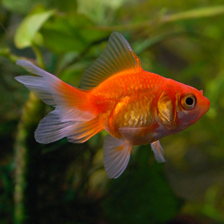

In [3]:
gold_fish = Image.open("D:\Akash\Machine Learning\Data_for_ML\goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [4]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [5]:
result = classifier.predict(gold_fish[np.newaxis, ...])
predicted_label_index = np.argmax(result)

predicted_label_index

2

In [6]:
image_labels = []
with open("D:\Akash\Machine Learning\Data_for_ML\ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [7]:
image_labels[predicted_label_index]

'goldfish'

# 3. Import Flower Datasets

In [8]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir="D:\Akash\Machine Learning\Data_for_ML", untar=True)

## 4. Data Visualization and processing

In [9]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos')

In [10]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}


flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [11]:
flowers_images_dict['roses'][:5]

[WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos/roses/10090824183_d02c613f10_m.jpg'),
 WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos/roses/102501987_3cdb8e5394_n.jpg'),
 WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos/roses/10503217854_e66a804309.jpg'),
 WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos/roses/10894627425_ec76bbc757_n.jpg'),
 WindowsPath('D:/Akash/Machine Learning/Data_for_ML/datasets/flower_photos/roses/110472418_87b6a3aa98_m.jpg')]

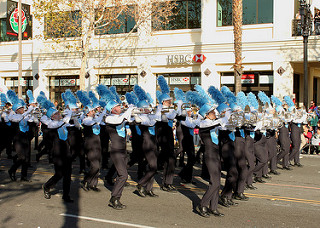

In [12]:
PIL.Image.open(flowers_images_dict['roses'][10])

In [14]:
x , y = [] , []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        x.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

# convert list into numpy array 
x = np.array(x)
y = np.array(y)

## 5. Train test splitting 

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=0)

## 6. scaling of 'x' datasets

In [16]:
x_train_scaled = x_train / 255
x_test_scaled = x_test / 255

## 7. Now take pre-trained model and retrain it using flowers images

In [17]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [18]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [19]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(x_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 991s 10s/step - loss: 0.8053 - acc: 0.6984
Epoch 2/5
86/86 [==============================] - 1031s 12s/step - loss: 0.4152 - acc: 0.8463
Epoch 3/5
86/86 [==============================] - 851s 10s/step - loss: 0.3256 - acc: 0.8895
Epoch 4/5
86/86 [==============================] - 842s 10s/step - loss: 0.2735 - acc: 0.9132
Epoch 5/5
86/86 [==============================] - 811s 9s/step - loss: 0.2341 - acc: 0.9310


In [21]:
model.evaluate(x_test_scaled,y_test)

29/29 [==============================] - 176s 6s/step - loss: 0.3588 - acc: 0.8747


[0.358756422996521, 0.8747276663780212]

# Evaluation Report

In [22]:
y_pred = model.predict(x_test_scaled)
y_pred_classes = [np.argmax(score) for score in tf.nn.softmax(y_pred)]
y_pred_classes[0]

In [ ]:
y_test[0]

In [ ]:
from sklearn.metrics import confusion_matrix , classification_report

print("Classification Report \n", classification_report(y_test , y_pred_classes))